In [13]:
from pathlib import Path

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import pyBigWig
import pysam

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

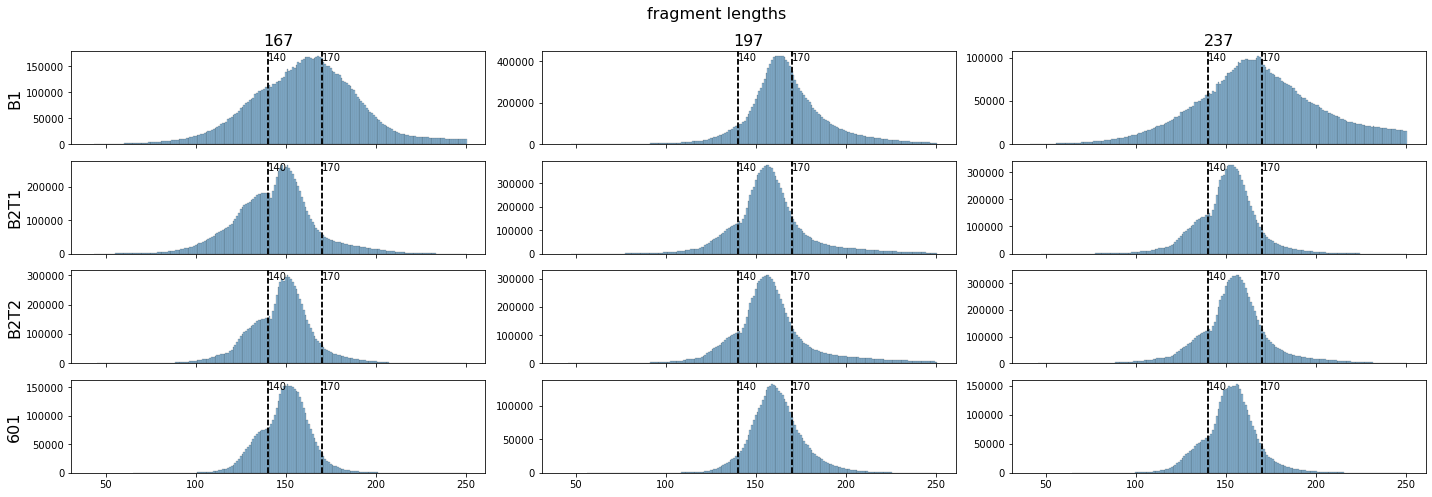

In [15]:
bam_files = [
    Path('MNases_06_2020', 'NG-25315_167_1_lib406963_6879_2_trimfiltered_max250.sorted.bam'),
    Path('MNases_06_2020', 'NG-25315_1972_1_lib402286_6844_1_trimfiltered_max250.sorted.bam'),
    Path('MNases_06_2020', 'NG-25315_237_1_lib406964_6879_2_trimfiltered_max250.sorted.bam'),

    Path('MNase_08_2023', 'NG-34039_167_4_1_lib713576_10294_1_trimfiltered_max250.sorted.bam'),
    Path('MNase_08_2023', 'NG-34039_197_2_27_1_lib713580_10294_1_trimfiltered_max250.sorted.bam'),
    Path('MNase_08_2023', 'NG-34039_237_44_1_lib713582_10294_1_trimfiltered_max250.sorted.bam'),

    Path('MNase_08_2023', 'NG-34039_167_4_2_lib713577_10294_1_trimfiltered_max250.sorted.bam'),
    Path('MNase_08_2023', 'NG-34039_197_2_27_2_lib713581_10294_1_trimfiltered_max250.sorted.bam'),
    Path('MNase_08_2023', 'NG-34039_237_44_2_lib713583_10294_1_trimfiltered_max250.sorted.bam'),

    Path('MNase_601', 'SRR13645559_167_max250.sorted.bam'),
    Path('MNase_601', 'SRR13645549_197_max250.sorted.bam'),
    Path('MNase_601', 'SRR13645545_237_max250.sorted.bam'),
    ]
titles = ['167', '197', '237']
ylabels = ['B1', 'B2T1', 'B2T2', '601']
fig, axes = plt.subplots(4, 3, figsize=(20, 7), facecolor='w', layout='tight', sharex=True)
fig.suptitle('fragment lengths', fontsize=16)
vlines = [140, 170]
for filename, ax in zip(bam_files, axes.flatten()):
    fraglens = pd.read_csv(f'{filename}.insert_sizes.txt', header=None)
    fraglens.columns = ['fragment_length']
    sns.histplot(fraglens, discrete=True, ax=ax, legend=False)
    ax.set_ylabel(None)
    for v in vlines:
        ax.axvline(x=v, color='k', linestyle='--')
        ax.axvline(x=v, color='k', linestyle='--')
        ax.annotate(str(v), xy=(v, 0.9), xycoords=('data', 'axes fraction'))
for j in range(3):
    axes[0, j].set_title(titles[j], fontsize=16)
for i in range(4):
    axes[i, 0].set_ylabel(ylabels[i], fontsize=16)

Text(0.5, 0.98, 'Mid points of fragments between 140 and 170bp')

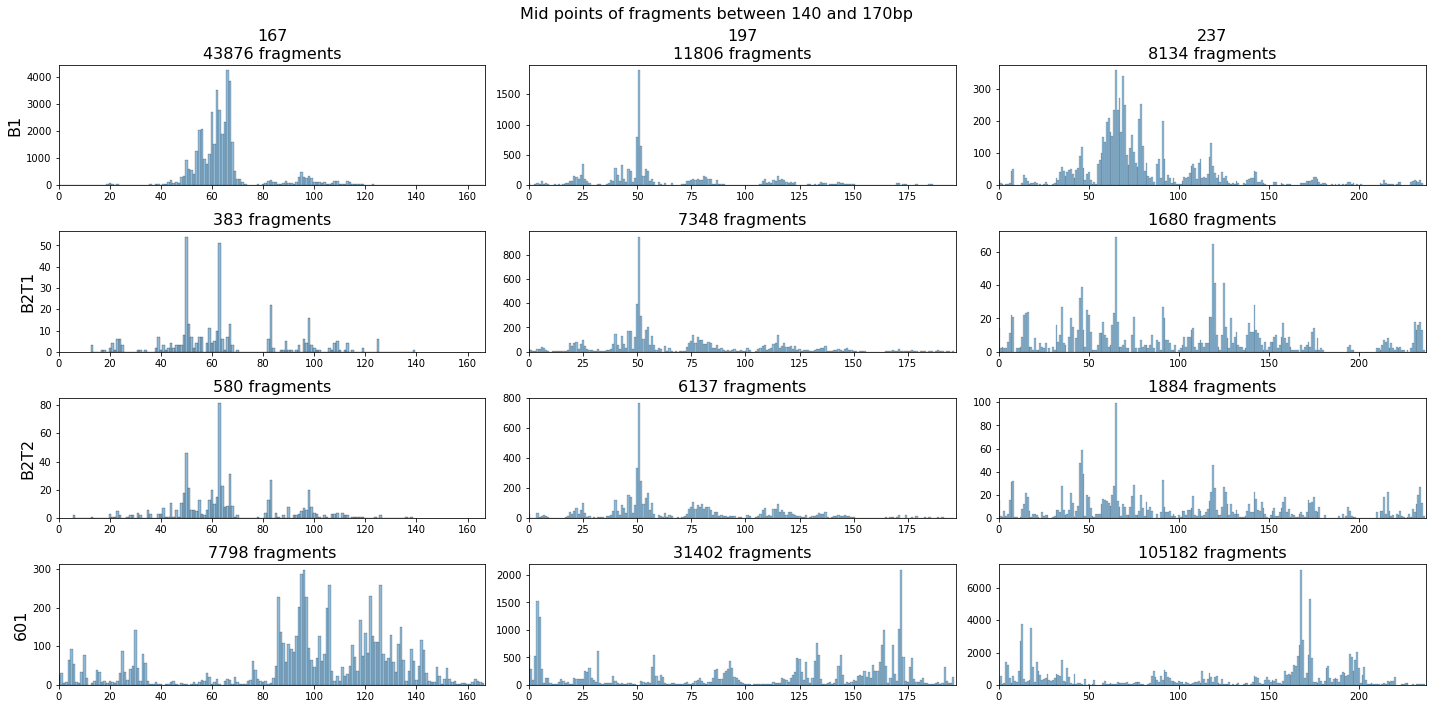

In [16]:
titles = ['167', '197', '237'] + [''] * 9
ylabels = ['B1', 'B2T1', 'B2T2', '601']
repids = ['167', '197b', '237'] * 3 + ['167_601', '197_601', '237_601']
minfragsize, maxfragsize = 140, 170
start = 4000
fig, axes = plt.subplots(4, 3, figsize=(20, 10), facecolor='w', layout='tight')
for bam_file, title, repid, ax in zip(bam_files, titles, repids, axes.flatten()):
    rlen = int(repid[:3])
    with pysam.AlignmentFile(bam_file, 'rb') as f:
        coords = []
        for read in f.fetch(contig=f'{repid}_7_4kbrf'):
            if (not read.is_reverse
                and read.is_proper_pair
                and read.template_length >= minfragsize
                and read.template_length <= maxfragsize
                and read.reference_start >= start
                and read.reference_start + read.template_length < start + 7*rlen):
                coords.append(read.reference_start + read.template_length // 2)
    coords = np.array(coords)
    rep_coords = (coords[(coords >= start+rlen) & (coords < start + 6*rlen)] - start) % rlen
    
    sns.histplot(pd.DataFrame(rep_coords, columns=['mid points']), discrete=True, ax=ax, legend=False)
    ax.set_ylabel(None)
    if title != '':
        ax.set_title(f'{title}\n{len(rep_coords)} fragments', fontsize=16)
    else:
        ax.set_title(f'{len(rep_coords)} fragments', fontsize=16)
    ax.set_xlim(0, rlen)
for i in range(4):
    axes[i, 0].set_ylabel(ylabels[i], fontsize=16)
fig.suptitle(f'Mid points of fragments between {minfragsize} and {maxfragsize}bp', fontsize=16)

In [17]:
def load_bw(filename, nantonum=True):
    labels = {}
    bw = pyBigWig.open(str(filename))
    for chr_id in bw.chroms():
        if nantonum:
            labels[chr_id] = np.nan_to_num(
                bw.values(chr_id, 0, -1, numpy=True))
        else:
            labels[chr_id] = bw.values(chr_id, 0, -1, numpy=True)
    bw.close()
    return labels

mnase2020_167 = load_bw(Path('MNases_06_2020', 'NG-25315_167_1_lib406963_6879_2_trimfiltered_max250_140-170_CPM.bw'))
mnase2020_197 = load_bw(Path('MNases_06_2020', 'NG-25315_1972_1_lib402286_6844_1_trimfiltered_max250_140-170_CPM.bw'))
mnase2020_237 = load_bw(Path('MNases_06_2020', 'NG-25315_237_1_lib406964_6879_2_trimfiltered_max250_140-170_CPM.bw'))

mnase2023_167_1 = load_bw(Path('MNase_08_2023', 'NG-34039_167_4_1_lib713576_10294_1_trimfiltered_max250_140-170_CPM.bw'))
mnase2023_167_2 = load_bw(Path('MNase_08_2023', 'NG-34039_167_4_2_lib713577_10294_1_trimfiltered_max250_140-170_CPM.bw'))
mnase2023_197_1 = load_bw(Path('MNase_08_2023', 'NG-34039_197_2_27_1_lib713580_10294_1_trimfiltered_max250_140-170_CPM.bw'))
mnase2023_197_2 = load_bw(Path('MNase_08_2023', 'NG-34039_197_2_27_2_lib713581_10294_1_trimfiltered_max250_140-170_CPM.bw'))
mnase2023_237_1 = load_bw(Path('MNase_08_2023', 'NG-34039_237_44_1_lib713582_10294_1_trimfiltered_max250_140-170_CPM.bw'))
mnase2023_237_2 = load_bw(Path('MNase_08_2023', 'NG-34039_237_44_2_lib713583_10294_1_trimfiltered_max250_140-170_CPM.bw'))

mnase601_167 = load_bw(Path('MNase_601', 'SRR13645559_167_max250_140-170_CPM.bw'))
mnase601_197 = load_bw(Path('MNase_601', 'SRR13645549_197_max250_140-170_CPM.bw'))
mnase601_237 = load_bw(Path('MNase_601', 'SRR13645545_237_max250_140-170_CPM.bw'))

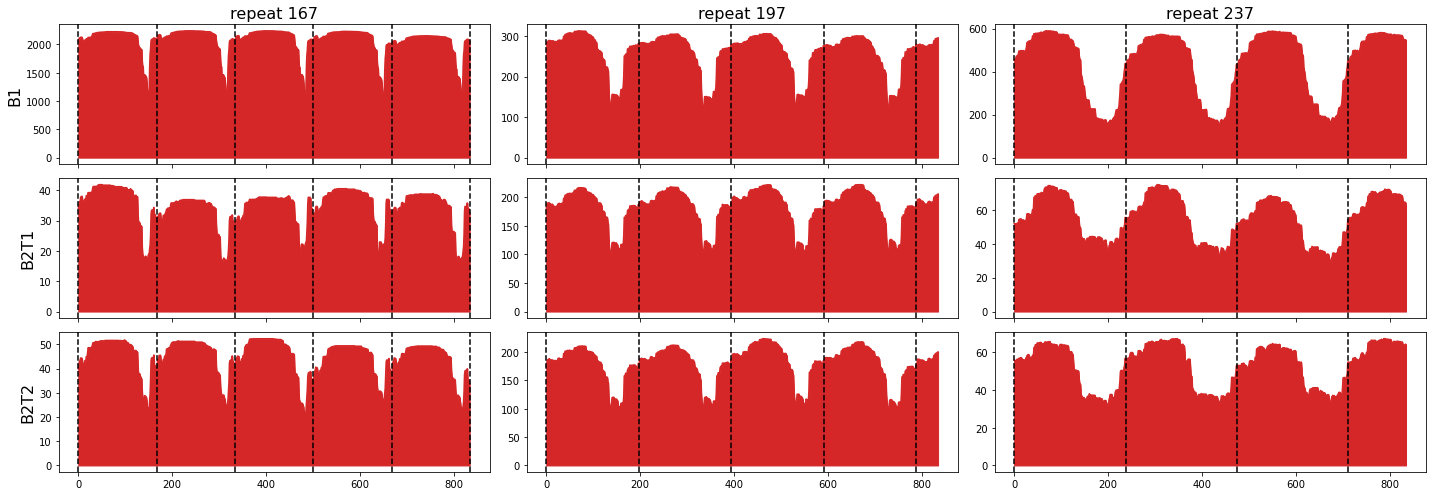

In [18]:
start = 4000
rstart = 4000
signals = np.array([[mnase2020_167, mnase2020_197, mnase2020_237],
                    [mnase2023_167_1, mnase2023_197_1, mnase2023_237_1],
                    [mnase2023_167_2, mnase2023_197_2, mnase2023_237_2]])
ylabels = ['B1', 'B2T1', 'B2T2']
repeats = ['167', '197b', '237']
fig, axes = plt.subplots(3, 3, figsize=(20, 7), facecolor='w', layout='tight', sharex='col')#, sharey='col')

for j in range(3):
    axes[0, j].set_title(f'repeat {repeats[j][:3]}', fontsize=16)
for i in range(3):
    axes[i, 0].set_ylabel(ylabels[i], fontsize=16)
    for j in range(3):
        ax = axes[i, j]
        signal = signals[i, j]
        rid = repeats[j]
        rlen = int(rid[:3])
        start = rstart + rlen
        stop = start + 5*167
        ax.plot(signal[f'{rid}_7_4kbrf'][start:stop], color=colors[3])
        ax.fill_between(np.arange(stop-start), signal[f'{rid}_7_4kbrf'][start:stop], color=colors[3])
        for reps in range(0, 6-j):
            ax.axvline(reps*rlen, color='k', linestyle='--')

In [29]:
model_name = 'weights_with_rev_compl_rep2'
with np.load(Path('Results_nucleosome', f'preds_{model_name}_on_repeats.npz')) as f:
    preds_syn = {k: f[k] for k in f.keys() if '601' not in k}
    preds_601 = {k: f[k] for k in f.keys() if '601' in k}

In [32]:
def target(n_reps, replen, final_len=None):
    amp = 0.3
    shift = 0.2
    nuclen = 147

    x_gauss = np.arange(1, nuclen)
    y_target_ = shift + amp*np.exp(-((x_gauss-((nuclen-1)/2))**2 / (nuclen**2/8)))
    y_target_ = np.append(y_target_, np.repeat(y_target_[-1],(replen - (nuclen-1)))) #linkers at last value
    y_target = np.tile(y_target_, n_reps)
    if final_len is not None:
        y_target = y_target[:final_len]
    return y_target


def moving_average(x, n=2, keepsize=False):
    if keepsize:
        x = np.concatenate([
            np.zeros(n // 2, dtype=x.dtype),
            x,
            np.zeros((n-1) // 2, dtype=x.dtype)])
    ret = np.cumsum(x)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

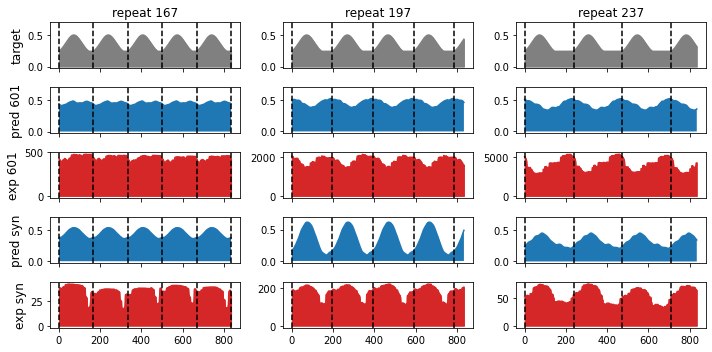

In [21]:
fig, axes = plt.subplots(5, 3, figsize=(10, 5), facecolor='w', layout='tight', sharex=True)

n_reps = 5
signals_601 = [mnase601_167, mnase601_197, mnase601_237]
repeats_601 = ['167_601', '197_601', '237_601']
signals_syn = [mnase2023_167_1, mnase2023_197_1, mnase2023_237_1]
repeats_syn = ['167', '197b', '237']
ylabels = ['target', 'pred 601', 'exp 601', 'pred syn', 'exp syn']

for j in range(3):
    rid = repeats_601[j]
    rlen = int(rid[:3])
    axes[0, j].set_title(f'repeat {rlen}', fontsize=12)

    # target
    targ = target(n_reps, rlen, 167*n_reps)
    axes[0, j].plot(targ, color='grey')
    axes[0, j].fill_between(np.arange(len(targ)), targ, color='grey')

    # 601 pred
    pred = preds_601[rid]
    start = 1000
    stop = start + n_reps*167
    values = moving_average(pred[start-4:stop+3], 8)
    axes[1, j].plot(values)
    axes[1, j].fill_between(np.arange(stop-start), values)
    # 601 signal
    signal = signals_601[j]
    start = 4000 + rlen
    stop = start + n_reps*167
    values = signal[f'{rid}_7_4kbrf'][start:stop]
    axes[2, j].plot(values, color=colors[3])
    axes[2, j].fill_between(np.arange(stop-start), values, color=colors[3])
    
    # syn pred
    rid = repeats_syn[j]
    pred = preds_syn[rid]
    start = 1000
    stop = start + n_reps*167
    values = moving_average(pred[start-4:stop+3], 8)
    axes[3, j].plot(values)
    axes[3, j].fill_between(np.arange(stop-start), values)
    # syn signal
    signal = signals_syn[j]
    start = 4000 + rlen
    stop = start + n_reps*167
    values = signal[f'{rid}_7_4kbrf'][start:stop]
    axes[4, j].plot(values, color=colors[3])
    axes[4, j].fill_between(np.arange(stop-start), values, color=colors[3])
    
    axes[0, j].set_ylim(top=0.7)
    axes[1, j].set_ylim(top=0.7)
    axes[3, j].set_ylim(top=0.7)

    # vlines and ylabels
    for i in range(5):
        for reps in range(0, 6-j):
            axes[i, j].axvline(reps*rlen, color='k', linestyle='--')
        axes[i, 0].set_ylabel(ylabels[i], fontsize=12)